# CAC 40 Stock Price Forecast with ARIMA & LSTM

### Reference Material

* CAC 40 data Donwload: https://www.euronext.com/en/products/indices/FR0003500008-XPAR
* Jupyter Notebook Connect with HDFS: http://nbviewer.jupyter.org/github/ofermend/IPython-notebooks/blob/master/blog-part-1.ipynb
* Time Series Prediction with LSTM: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

---

## PART 1. Data pre processing

Start by uploading data from an API or from your Local machine

### 1. Import Dataset 


* if you are are using an API search for datareader

In [296]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.stattools as stool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

CAC40 = pd.read_csv("CAC 40_Historical_price.csv", sep=";") # Read the data
print(CAC40)

           Date     Open     High      Low    Close  Number of Shares  \
0    01/02/2021  5441.43  5481.67  5429.78  5461.68                 0   
1    02/02/2021  5510.62  5574.77  5509.24  5563.11                 0   
2    03/02/2021  5610.59  5626.41  5554.09  5563.05                 0   
3    04/02/2021  5568.39  5613.95  5566.58  5608.54                 0   
4    05/02/2021  5638.74  5673.03  5627.84  5659.26                 0   
..          ...      ...      ...      ...      ...               ...   
511  24/01/2023  7053.04  7064.69  7011.40  7050.48                 0   
512  25/01/2023  7057.82  7070.84  6999.93  7043.88                 0   
513  26/01/2023  7095.11  7117.53  7078.02  7095.99                 0   
514  27/01/2023  7085.47  7117.48  7062.69  7097.21                 0   
515  30/01/2023  7054.24  7103.66  7030.95  7082.01                 0   

     Number of Trades    Turnover  
0                   0  3103597509  
1                   0  4098061444  
2              

### 1.2 Display a summary of statistical measure of this data

In [297]:
summary = CAC40.describe()
print(summary)

              Open         High          Low        Close  Number of Shares  \
count   516.000000   516.000000   516.000000   516.000000             516.0   
mean   6481.573159  6524.132074  6439.778372  6484.160000               0.0   
std     390.193170   385.581800   390.493250   387.442124               0.0   
min    5441.430000  5481.670000  5429.780000  5461.680000               0.0   
25%    6213.920000  6260.670000  6168.105000  6220.915000               0.0   
50%    6525.070000  6569.750000  6481.910000  6523.940000               0.0   
75%    6711.335000  6756.737500  6679.012500  6728.337500               0.0   
max    7320.480000  7384.860000  7313.530000  7376.370000               0.0   

       Number of Trades      Turnover  
count             516.0  5.160000e+02  
mean                0.0  3.596529e+09  
std                 0.0  1.389801e+09  
min                 0.0  0.000000e+00  
25%                 0.0  2.896639e+09  
50%                 0.0  3.333907e+09  
75%     

### 1.3. Change String Date to Datetime Format

In [298]:
CAC40["Date"] = pd.to_datetime(CAC40["Date"], format="%d/%m/%Y")

### 1.4. Set Datetime to Index

In [299]:
CAC40.set_index("Date", inplace=True)

### 1.5. Feature Selection & Data Resampling

In [300]:
CAC40 = CAC40[['Open', 'High', 'Low', 'Close']]

df_monthly = CAC40.resample('M').mean()

### 1.6. Split Dataset to train and test data

In [301]:
train, test = train_test_split(CAC40, test_size=0.2, shuffle=False)

### 1.7. Plot Training Data & Observation Data Trends¶

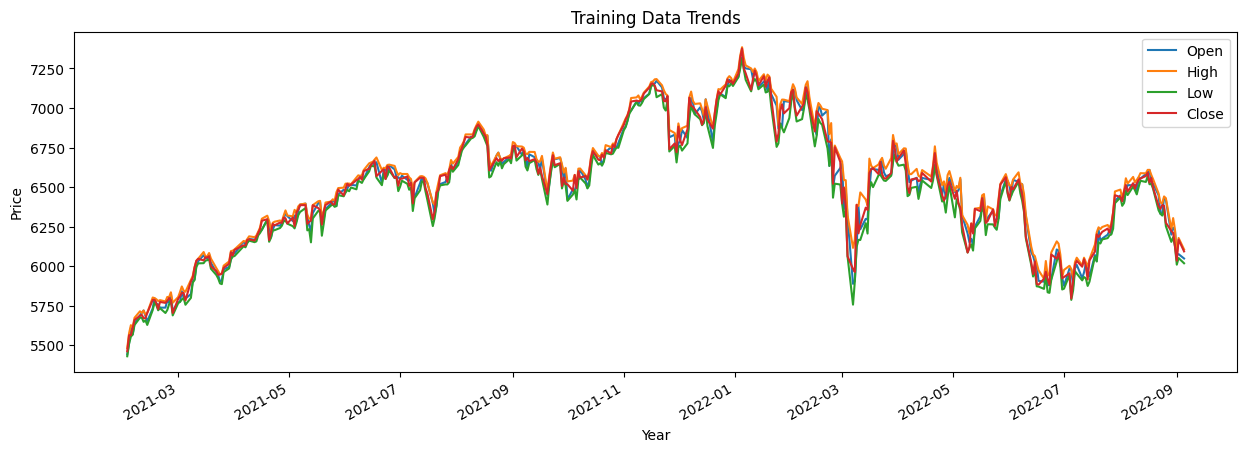

In [302]:
train.plot(figsize=(15, 5))
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Training Data Trends")
plt.show()

---

## Part 2. CAC 40 Stock Price Forecast with ARIMA

### 2.1. Make First Order Difference or Second Order Difference

#### 2.1.1. Make First Order Difference

In [303]:
CAC40['Close_Diff'] = CAC40['Close'].diff()
CAC40.dropna(inplace=True)

#### 2.2.2. Plot the Training Data After the First Order Difference

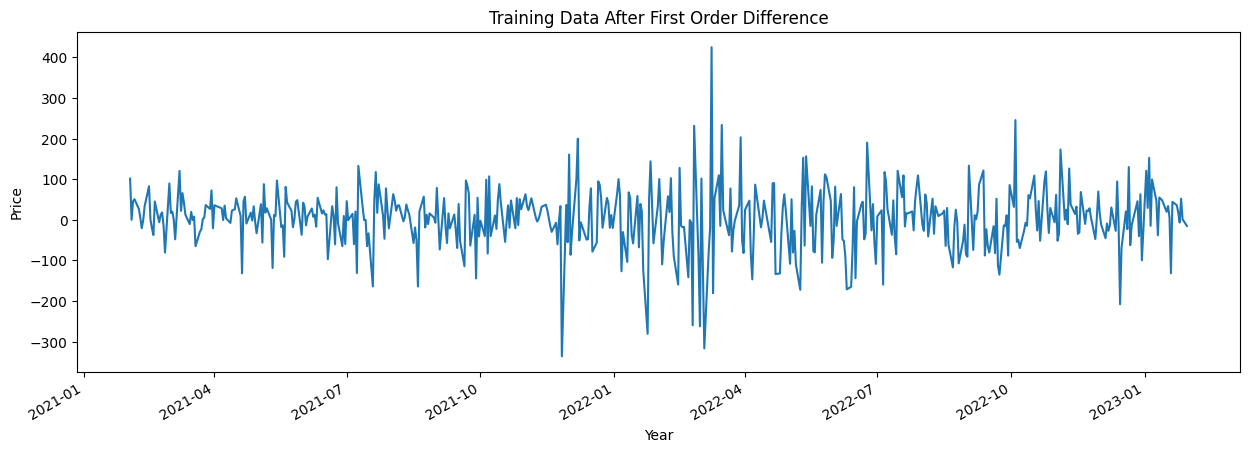

In [304]:
CAC40['Close_Diff'].plot(figsize=(15, 5))
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Training Data After First Order Difference")
plt.show()

### 2.2. Draw ACF&PACF Chart and Select Hyperparameter q&p

#### 2.2.1. Draw ACF Chart and Chose Hyperparameter q in MA Model

[ 1.         -0.04251312 -0.0513155  -0.00598453  0.02215833  0.04657868
 -0.02119233 -0.04824179  0.10220959 -0.02524745 -0.00500322  0.03115681
 -0.09040714 -0.05153915  0.04222088  0.02664101  0.04554767 -0.07168826
 -0.05839874 -0.00266736 -0.01881395  0.01954867  0.01378262 -0.0497554
 -0.06776171  0.05852292  0.00481735 -0.0584983  -0.04205811  0.10931889
  0.06859922 -0.04648166 -0.09445807  0.04689777 -0.02948531 -0.05847997
 -0.01752954  0.01141618 -0.04060615  0.00131724  0.03454089]


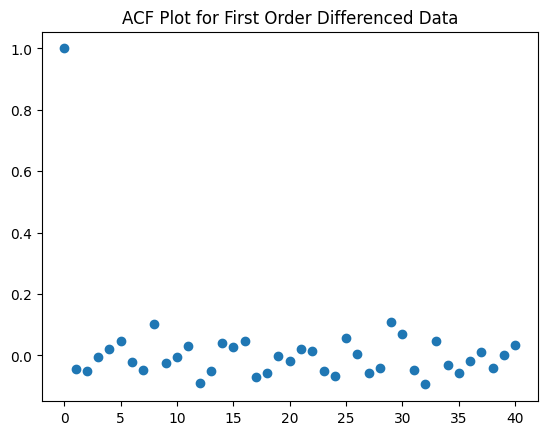

In [305]:
acf = stool.acf(CAC40['Close_Diff'],nlags=40,alpha=0.05)
print(acf[0])
plt.scatter(range(41),acf[0])
plt.title("ACF Plot for First Order Differenced Data")
plt.show()

#### 2.2.2. Draw PACF Chart and Chose Hyperparameter p in AR Model

[ 1.00000000e+00 -4.25958337e-02 -5.34269070e-02 -1.06566397e-02
  1.89177346e-02  4.82761722e-02 -1.51136732e-02 -4.56873411e-02
  9.87562247e-02 -2.42971721e-02  7.27042860e-04  3.50595545e-02
 -9.27691717e-02 -6.85565324e-02  3.56669152e-02  3.07612090e-02
  4.18180773e-02 -5.10806785e-02 -6.08525925e-02 -3.60276815e-02
 -1.63534870e-02  3.03498387e-02  1.69935311e-02 -4.31385946e-02
 -9.68468070e-02  4.82711175e-02  1.15695235e-02 -4.97812385e-02
 -2.24539967e-02  1.04705134e-01  4.36232078e-02 -3.88867023e-02
 -7.72074365e-02  3.61922735e-02 -4.44063427e-02 -6.90583017e-02
 -3.27365167e-02 -1.12996360e-02 -5.10022545e-02  8.99643714e-03
  5.00149211e-02]


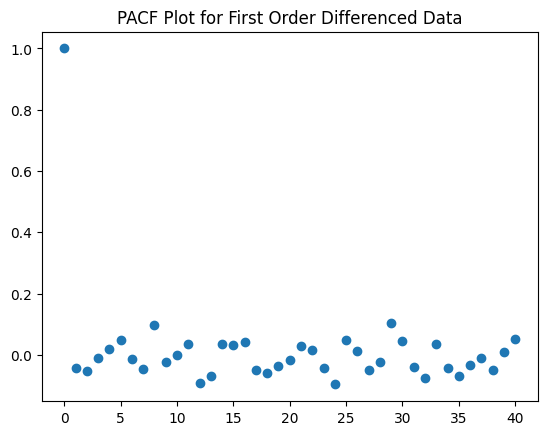

In [306]:
pacf = stool.pacf(CAC40['Close_Diff'],nlags=40,alpha=0.05)
print(pacf[0])
plt.scatter(range(41),pacf[0])
plt.title("PACF Plot for First Order Differenced Data")
plt.show()

### 2.3. Define then train the ARIMA Model

In [307]:
p = 5
d = 1
q = 5

model = ARIMA(CAC40['Close_Diff'], order=(p, d, q))
model = model.fit()

D:\jonat\Programmation\princing2\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\jonat\Programmation\princing2\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\jonat\Programmation\princing2\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\jonat\Programmation\princing2\venv\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

### 2.4. Use ARIMA Model to Predict CAC 40 Stock Price After November 2022 (Weekly Forecast)

#### 2.4.1. Use ARIMA Model to Predict

In [308]:
pred = model.get_prediction(start=454, end=475) #454 : 01/11/2022 ; 475 : 30/11/2022
pred_conf = pred.conf_int()

#### 2.4.2. Evaluation the arima predicted model using RMSE

In [309]:
actual = test['Close']['2022-11-01':'2022-12-31']

rmse = np.sqrt(((pred.predicted_mean - actual) ** 2).mean())

print("RMSE:", rmse)

RMSE: 6617.265812579245


#### 2.4.3. Plot the Predict Result

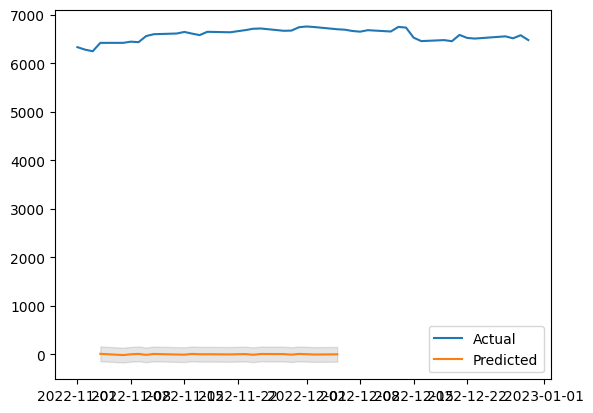

In [310]:
plt.plot(actual, label='Actual')
plt.plot(pred.predicted_mean, label='Predicted')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='k', alpha=.1)
plt.legend()
plt.show()

---

## Part 3. CAC 40 Stock Price Forecast with LSTM [optional]

#### instead of using the ARIMA model use LSTM and do the same steps as ARIMA one. You may also need to add a normalisation step in the pre processing part